# Time Series Predictions with Facebook Prophet

In [1]:
import pandas as pd
import numpy as np
from fbprophet import Prophet

import datetime
import matplotlib.pyplot as plt

%matplotlib inline
import logging
logging.getLogger('fbprophet').setLevel(logging.ERROR)
import warnings
warnings.filterwarnings("ignore")
%config InlineBackend.figure_format = 'retina'

## Python API

Prophet follows the `sklearn` model API.  We create an instance of the `Prophet` class and then call its `fit` and `predict` methods.  

The input to Prophet is always a dataframe with two columns: `ds` and `y`.  The `ds` (datestamp) column must contain a date or datetime (either is fine). The `y` column must be numeric, and represents the measurement we wish to forecast.

As an example, let's look at a time series of daily page views for the [Vodafone Wikipedia Page](https://en.wikipedia.org/wiki/Vodafone).  We scraped this data using the [Wikipedia PageView Analysis](https://tools.wmflabs.org/pageviews/).  The article daily visits provides a nice example because it illustrates some of Prophet's features, like multiple seasonality, changing growth rates, and the ability to model special days (such as a launch in a new country). The CSV is available [here](pageviews.csv).

First we'll import the data and log-transform the y variable.

In [2]:
df = pd.read_csv('pageviews.csv')
df['y'] = np.log(df['Vodafone'])
df['ds'] = df['Date']
df = df.drop(['Vodafone', 'Date'], axis=1)
df.head()

,y,ds
0,7.648740,2015-07-01
1,7.604894,2015-07-02
2,7.437795,2015-07-03
3,7.187657,2015-07-04
4,7.294377,2015-07-05


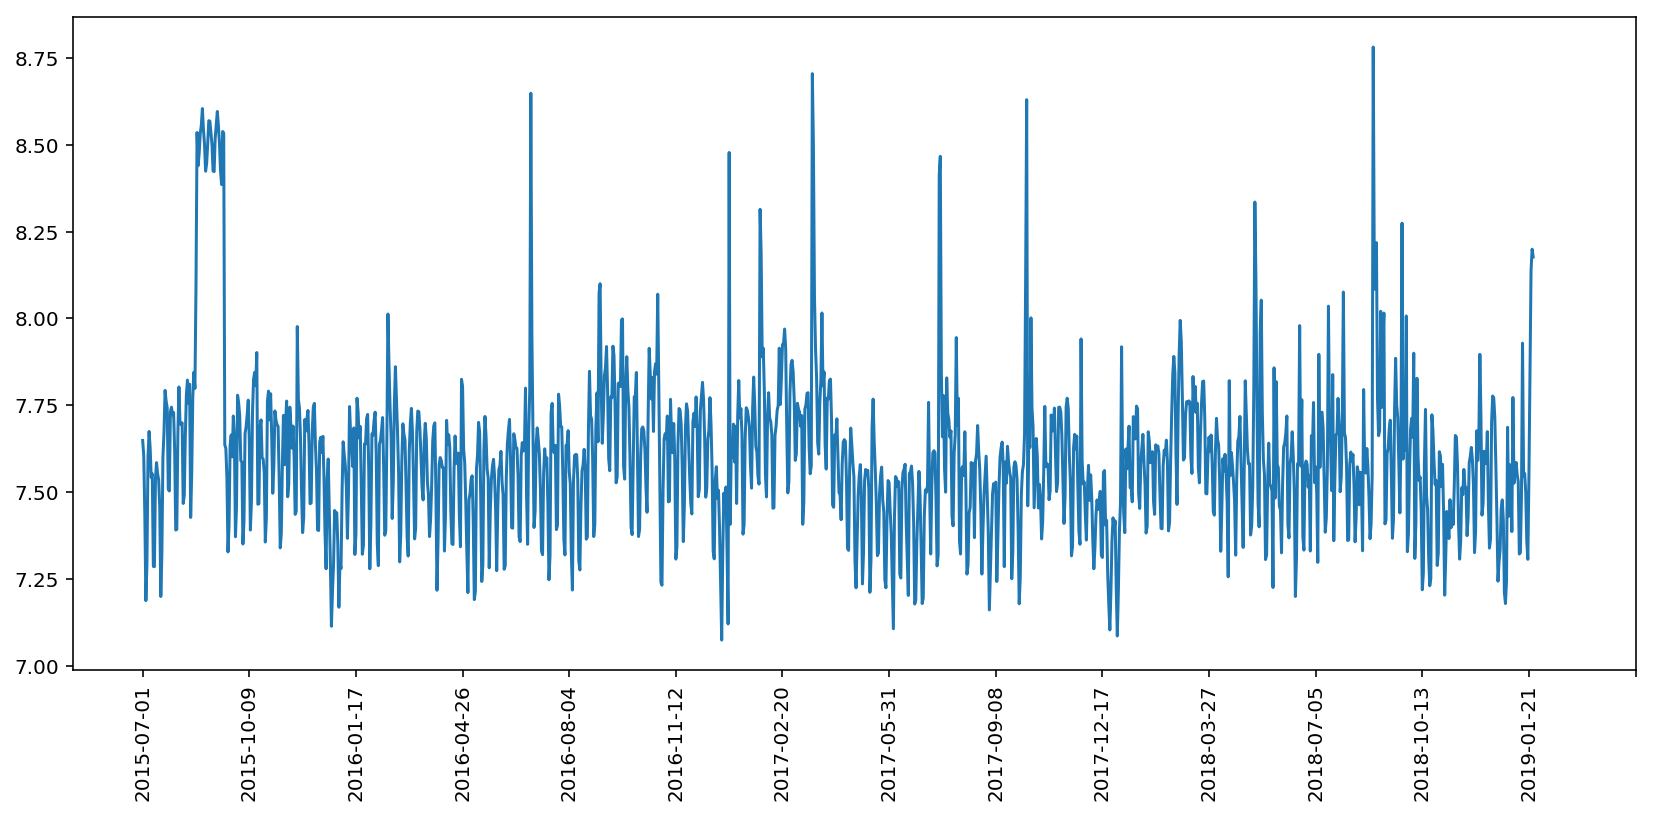

In [3]:
plt.figure(figsize=(14, 6))

plt.plot(df['ds'], df['y'])

plt.xticks([x*100 for x in range(15)], rotation=90)
plt.show();

In [4]:
weird_dates = df[0:200][(df[0:200].y > 8)]['ds'].values
weird_dates = list(weird_dates)
#add a future date to list of dates
weird_dates.append('2019-07-11')

In [5]:
holidays = pd.DataFrame({
  'holiday': '2015_anamoly',
  'ds': pd.to_datetime(weird_dates)
})

holidays.tail()

,holiday,ds
23,2015_anamoly,2015-09-12
24,2015_anamoly,2015-09-13
25,2015_anamoly,2015-09-14
26,2015_anamoly,2015-09-15
27,2015_anamoly,2019-07-11


We fit the model by instantiating a new `Prophet` object.  Any settings to the forecasting procedure are passed into the constructor.  Then you call its `fit` method and pass in the historical dataframe. Fitting should take 1-5 seconds.

Predictions are then made on a dataframe with a column `ds` containing the dates for which a prediction is to be made. You can get a suitable dataframe that extends into the future a specified number of days using the helper method `Prophet.make_future_dataframe`. By default it will also include the dates from the history, so we will see the model fit as well. 

In [6]:
m = Prophet(holidays=holidays)
m.fit(df);

In [7]:
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
1665,2020-01-21
1666,2020-01-22
1667,2020-01-23
1668,2020-01-24
1669,2020-01-25


The `predict` method will assign each row in `future` a predicted value which it names `yhat`.  If you pass in historical dates, it will provide an in-sample fit. The `forecast` object here is a new dataframe that includes a column `yhat` with the forecast, as well as columns for components and uncertainty intervals.

In [8]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1665,2020-01-21,7.648785,7.366823,7.913793
1666,2020-01-22,7.631241,7.349986,7.887836
1667,2020-01-23,7.608117,7.328657,7.856756
1668,2020-01-24,7.541595,7.258637,7.802220
1669,2020-01-25,7.341680,7.057182,7.600439


You can plot the forecast by calling the `Prophet.plot` method and passing in your forecast dataframe.

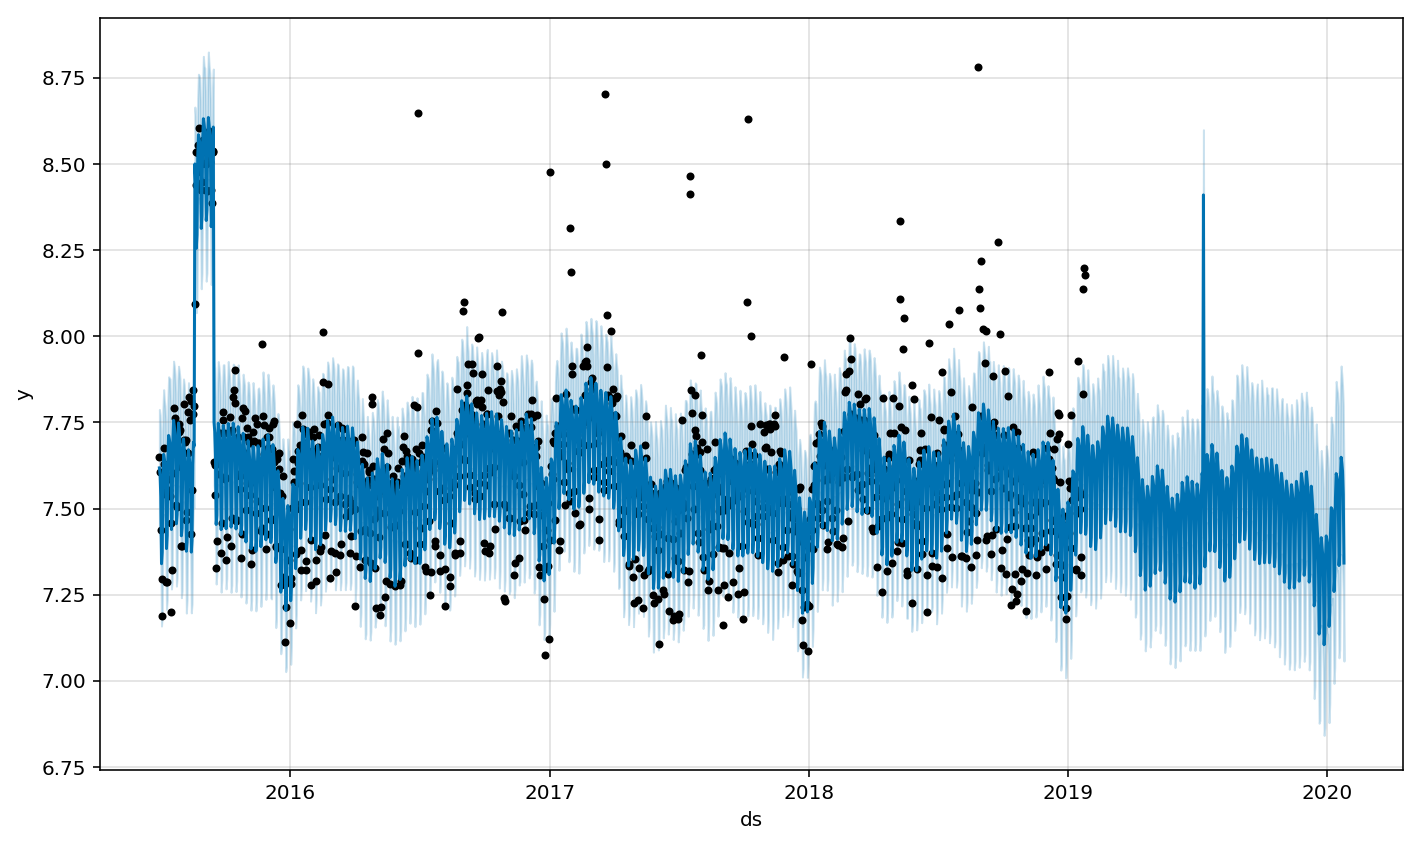

In [9]:
m.plot(forecast);

If you want to see the forecast components, you can use the `Prophet.plot_components` method.  By default you'll see the trend, yearly seasonality, and weekly seasonality of the time series.  If you include holidays, you'll see those here, too.

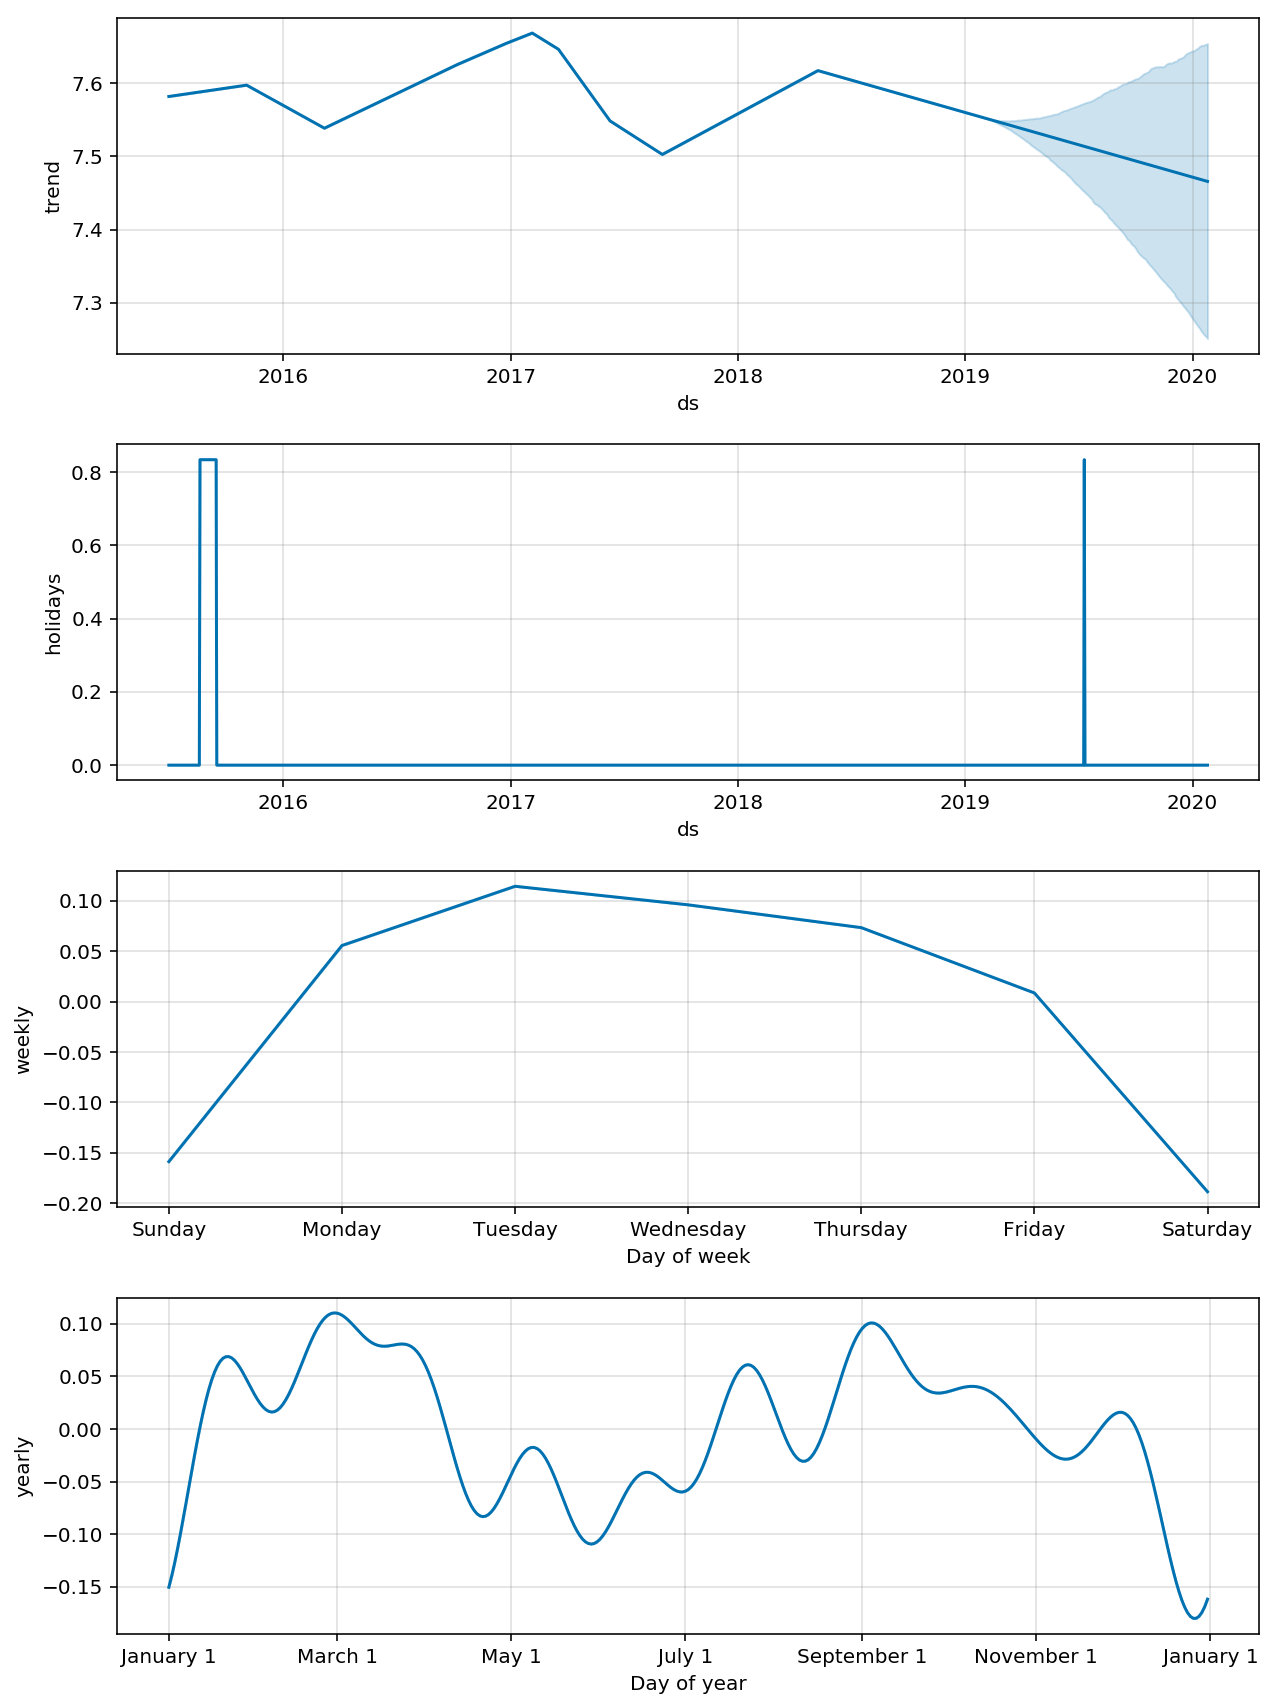

In [10]:
m.plot_components(forecast);

More details about the options available for each method are available in the docstrings, for example, via `help(Prophet)` or `help(Prophet.fit)`.